In [9]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import tensorly as tl
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

import tensorly as tl

from tqdm.auto import tqdm, trange

import matplotlib.pyplot as plt


torch.manual_seed(0)

torch.set_default_tensor_type(torch.DoubleTensor)


tl.set_backend('pytorch')

class KernelRBF(nn.Module):
    
    def __init__(self, jitter=1e-5):
        super().__init__()     
        self.register_buffer('jitter', torch.tensor(jitter))
        self.log_amp = nn.Parameter(torch.tensor(0.0))
        self.log_ls = nn.Parameter(torch.tensor(0.0))
        
    def matrix(self, X):
        K = self.cross(X, X)
        Ijit = self.jitter*torch.eye(X.shape[0], device=self.jitter.device)
        K = K + Ijit
        return K

    def cross(self, X1, X2):
        norm1 = torch.reshape(torch.sum(torch.square(X1), dim=1), [-1,1])
        norm2 = torch.reshape(torch.sum(torch.square(X2), dim=1), [1,-1])        
        K = norm1-2.0*torch.matmul(X1,X2.T) + norm2
        K = torch.exp(-1.0*K/torch.exp(self.log_ls))
        return K
    
    
class KernelARD(nn.Module):
    def __init__(self, jitter=1e-5):
        super().__init__()     
        self.register_buffer('jitter', torch.tensor(jitter))
        self.log_amp = nn.Parameter(torch.tensor(0.0))
        self.log_ls = nn.Parameter(torch.tensor(0.0))
        
    def matrix(self, X):
        K = self.cross(X, X)
        Ijit = self.jitter*torch.eye(X.shape[0], device=self.jitter.device)
        K = K + Ijit
        return K

    def cross(self, X1, X2):
        norm1 = torch.reshape(torch.sum(torch.square(X1), dim=1), [-1,1])
        norm2 = torch.reshape(torch.sum(torch.square(X2), dim=1), [1,-1])        
        K = norm1-2.0*torch.matmul(X1,X2.T) + norm2
        K = torch.exp(self.log_amp)*torch.exp(-1.0*K/torch.exp(self.log_ls))
        return K

class ScalableGPRN(nn.Module):
    
    def __init__(
        self,
        in_dim: int,  
        rank: int,   
        meshes: list, 
        ntr: int,
        jitter: float=1e-5,
    ):
        
        super().__init__()
        
        assert len(meshes) == 2 # restrict 2D spatial-temporal 
        
        self.in_dim = in_dim
        self.rank = rank
        self.meshes = meshes

        self.kerF = KernelARD(jitter)
        self.kerW = KernelARD(jitter)
        
        self.dimd1 = meshes[0]
        self.dimd2 = meshes[1]
        self.dimK = rank
        self.dimN = ntr
        
        self.Fmu = nn.Parameter(torch.zeros([self.dimN, self.dimK]))
        self.Wmu = nn.Parameter(torch.zeros([self.dimN, self.dimd1*self.dimd2, self.dimK]))

        
        nn.init.xavier_normal_(self.Fmu)
        nn.init.xavier_normal_(self.Wmu)
        
        init_chol=1.0

        self.chol_F_N = nn.Parameter(init_chol*torch.eye(self.dimN))
        self.chol_F_K = nn.Parameter(init_chol*torch.eye(self.dimK))
        
        self.chol_W_N = nn.Parameter(init_chol*torch.eye(self.dimN))
        self.chol_W_K = nn.Parameter(init_chol*torch.eye(self.dimK))
        self.chol_W_d1 = nn.Parameter(init_chol*torch.eye(self.dimd1))
        self.chol_W_d2 = nn.Parameter(init_chol*torch.eye(self.dimd2))

        
        self.log_tau = nn.Parameter(torch.tensor(0.0))
        
        self.register_buffer('dummy', torch.tensor([]))
        
        
    def _eval_kld_F(self, X):
        
        Kf = self.kerF.matrix(X)
        
        
        LN = torch.tril(self.chol_F_N)
        LK = torch.tril(self.chol_F_K)
        
        SN = torch.mm(LN, LN.T)
        SK = torch.mm(LK, LK.T)

        trace_term = torch.trace(torch.linalg.solve(Kf, SN))*torch.trace(SK)
        quad_term = torch.trace(torch.linalg.solve(Kf, torch.mm(self.Fmu, self.Fmu.T)))

        chol_Kf = torch.linalg.cholesky(Kf)
        logdet_term2 = self.dimK*torch.sum(torch.log(torch.square(torch.diag(chol_Kf))))
        logdet_term1 = self.dimK*torch.sum(torch.log(torch.square(torch.diag(LN)))) +\
                       self.dimN*torch.sum(torch.log(torch.square(torch.diag(LK))))
        
        
        kld_f = 0.5*(logdet_term2-logdet_term1-self.dimK*self.dimN+trace_term+quad_term)
        
        return kld_f
    
    
    def _eval_kld_W(self, X):
        
        Kw = self.kerW.matrix(X)
        
         
        LN = torch.tril(self.chol_W_N)
        LK = torch.tril(self.chol_W_K)
        Ld1 = torch.tril(self.chol_W_d1)
        Ld2 = torch.tril(self.chol_W_d2)
        
        SN = torch.mm(LN, LN.T)
        SK = torch.mm(LK, LK.T)
        Sd1 = torch.mm(Ld1, Ld1.T)
        Sd2 = torch.mm(Ld2, Ld2.T)

         
        trace_term = torch.trace(torch.linalg.solve(Kw, SN))*torch.trace(SK)*torch.trace(Sd1)*torch.trace(Sd2)
        U = self.Wmu.flatten(1,-1)
        quad_term = torch.trace(torch.linalg.solve(Kw, torch.mm(U, U.T)))

        D = self.dimd1*self.dimd2*self.dimK*self.dimN
        chol_Kw = torch.linalg.cholesky(Kw)
        logdet_term2 = (D/self.dimN)*torch.sum(torch.log(torch.square(torch.diag(chol_Kw))))
        logdet_term1 = (D/self.dimN)*torch.sum(torch.log(torch.square(torch.diag(LN)))) +\
                       (D/self.dimK)*torch.sum(torch.log(torch.square(torch.diag(LK)))) +\
                       (D/self.dimd1)*torch.sum(torch.log(torch.square(torch.diag(Ld1)))) +\
                       (D/self.dimd2)*torch.sum(torch.log(torch.square(torch.diag(Ld2))))
        
        kld_w = 0.5*(logdet_term2-logdet_term1-D+trace_term+quad_term)
        
        return kld_w
    
    
    def _eval_llh(self, X, y):
        
        assert X.shape[0] == self.dimN
        assert X.shape[0] == y.shape[0]
        
        N = X.shape[0]
        out_dim = self.dimd1*self.dimd2
        assert out_dim == y.shape[1]
        
        LN = torch.tril(self.chol_W_N)
        LK = torch.tril(self.chol_W_K)
        Ld1 = torch.tril(self.chol_W_d1)
        Ld2 = torch.tril(self.chol_W_d2)
        
        SN = torch.mm(LN, LN.T)
        SK = torch.mm(LK, LK.T)
        Sd1 = torch.mm(Ld1, Ld1.T)
        Sd2 = torch.mm(Ld2, Ld2.T)
        
        AN = torch.tril(self.chol_F_N)
        AK = torch.tril(self.chol_F_K)
        
        VN = torch.mm(AN, AN.T)
        VK = torch.mm(AK, AK.T)
        
        llh_list = []

        Eqhnhn = torch.einsum('k,ij->kij', torch.diag(VN), VK) +\
                torch.einsum('bi,bj->bij', self.Fmu, self.Fmu)
        
        EqWnWn = torch.trace(Sd1)*torch.trace(Sd2)*torch.einsum('k,ij->kij', torch.diag(SN), SK) +\
                torch.bmm(self.Wmu.permute(0,2,1), self.Wmu)
        
        trace_term = torch.diagonal(
            torch.bmm(EqWnWn,Eqhnhn),
            dim1=-2,
            dim2=-1,
        ).sum(1).reshape([-1,1])
        
        Wnhn = torch.bmm(
            self.Wmu,
            self.Fmu.unsqueeze(-1),
        ).squeeze(-1)
        
        ynWnhn = torch.sum(y*Wnhn, dim=1, keepdims=True)
        
        ynyn = torch.sum(torch.square(y), dim=1, keepdims=True)
        
        quad_term = -0.5*torch.exp(self.log_tau)*(ynyn-2*ynWnhn+trace_term)
        
        llh = -0.5*out_dim*np.log(2*np.pi) + 0.5*out_dim*self.log_tau + quad_term
        
        return llh.sum()

    
    def eval_nelbo(self, X, y):
        
        llh = self._eval_llh(X, y)
        kld_W = self._eval_kld_W(X)
        kld_F = self._eval_kld_F(X)
        
        elbo = llh - kld_W - kld_F
        
        return -elbo 

    def forward(self, X, y, Xstar):
        
        N = X.shape[0]
        assert Xstar.ndim == 2
        M = Xstar.shape[0]

        Kw11 = self.kerW.matrix(X)
        Kw12 = self.kerW.cross(X, Xstar)
        Kw11InvKw12 = torch.linalg.solve(Kw11, Kw12)
        
        Wtr = torch.unsqueeze(torch.permute(self.Wmu, (1,2,0)), -2)
        
        Wstar_mu = torch.permute(torch.tensordot(Wtr, Kw11InvKw12, dims=([3],[0])).squeeze(-2), (2,0,1))
        
        
        Kf11 = self.kerF.matrix(X)
        Kf12 = self.kerF.cross(X, Xstar)
        
        Kf11InvKf12 = torch.linalg.solve(Kf11, Kf12)
        
        Ftr = torch.unsqueeze(torch.permute(self.Fmu,(1,0)),-2)
        
        Fstar_mu = torch.permute(torch.tensordot(Ftr, Kf11InvKf12, dims=([2], [0])).squeeze(-2), (1,0))
        
        ystar = torch.bmm(
            Wstar_mu,
            Fstar_mu.unsqueeze(-1)
        ).squeeze(-1)
        
        return ystar
    
    def forward_samples(self, X, y, Xstar, ns=50):
        
        N = X.shape[0]
        assert Xstar.ndim == 2
        M = Xstar.shape[0]
        
        Kw11 = self.kerW.matrix(X)
        Kw12 = self.kerW.cross(X, Xstar)
        Kw11InvKw12 = torch.linalg.solve(Kw11, Kw12)
        
        Wtr = torch.unsqueeze(torch.permute(self.Wmu, (1,2,0)), -2)
        
        Wstar_mu = torch.permute(torch.tensordot(Wtr, Kw11InvKw12, dims=([3],[0])).squeeze(-2), (2,0,1))
        
        Kw22 = self.kerW.matrix(Xstar)

        Lw11 = torch.linalg.cholesky(Kw11)
        vw = torch.linalg.solve(Lw11, Kw12)
        
        Wstar_V = Kw22-torch.mm(vw.T, vw)
        Wstar_std = torch.diag(torch.sqrt(torch.diag(Wstar_V)))
        
        Kf11 = self.kerF.matrix(X)
        Kf12 = self.kerF.cross(X, Xstar)
        Kf22 = self.kerF.matrix(Xstar)
        
        Kf11InvKf12 = torch.linalg.solve(Kf11, Kf12)
        
        Ftr = torch.unsqueeze(torch.permute(self.Fmu,(1,0)),-2)
        
        Fstar_mu = torch.permute(torch.tensordot(Ftr, Kf11InvKf12, dims=([2], [0])).squeeze(-2), (1,0))
        
        Lf11 = torch.linalg.cholesky(Kf11)
        vf = torch.linalg.solve(Lf11, Kf12)
        
        Fstar_V = Kf22-torch.mm(vf.T, vf)
        
        Fstar_std = torch.diag(torch.sqrt(torch.diag(Fstar_V)))
        
        epsiW = torch.randn(size=[ns, M, self.dimd1, self.dimd2, self.dimK]).to(self.dummy.device)
        epsiF = torch.randn(size=[ns, M, self.dimK]).to(self.dummy.device)
        
        LM = Wstar_std
        LK = torch.tril(self.chol_W_K)
        Ld1 = torch.tril(self.chol_W_d1)
        Ld2 = torch.tril(self.chol_W_d2)
        
        AM = Fstar_std
        AK = torch.tril(self.chol_F_K)
        
        Wposts_fact =  tl.tenalg.multi_mode_dot(
            tensor=epsiW, 
            matrix_or_vec_list=[
                LM, 
                Ld1,
                Ld2, 
                LK
            ],
            modes=[1,2,3,4]
        ) + Wstar_mu.reshape([M, self.dimd1, self.dimd2, self.dimK])
        
        Wposts = Wposts_fact.reshape([ns, M, self.dimd1*self.dimd2, self.dimK])
        
        
        Fposts =  tl.tenalg.multi_mode_dot(
            tensor=epsiF, 
            matrix_or_vec_list=[
                AM,
                AK
            ],
            modes=[1,2]
        ) + Fstar_mu
        
        Yposts = torch.einsum(
            'sbij, sbjk->sbik',
            Wposts,
            Fposts.unsqueeze(-1)
        ).squeeze(-1) # samples batch matrix multiplication
        
        
        return Yposts
        


    def eval_rmse(self, X, y, Xstar, ystar):
        with torch.no_grad():
            pred = self.forward(X, y, Xstar)
            nrmse = torch.sqrt(torch.mean(torch.square(ystar-pred)))/torch.sqrt(torch.square(ystar).mean())
            return nrmse
        


In [13]:
device = torch.device('cpu')

Xtr = torch.tensor(np.load('Xtr.npy')).to(device)
Xte = torch.tensor(np.load('Xte.npy')).to(device)
ytr = torch.tensor(np.load('ytr.npy')).to(device)
yte = torch.tensor(np.load('yte.npy')).to(device)

# print(Xtr.shape)
# print(ytr.shape)
# print(Xte.shape)
# print(yte.shape)

input_dim = Xtr.shape[1]
N = Xtr.shape[0]
    
model = ScalableGPRN(
    input_dim, 
    rank=20, 
    meshes=[64,64], 
    ntr=N, 
    jitter=1e-5,
).to(device)


max_epochs = 10000

optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, 'min', min_lr=1e-4)
sum_rmse_te = np.zeros(50)
x_axis = np.zeros(50)

for ie in tqdm(range(max_epochs)):
    
    loss = model.eval_nelbo(Xtr, ytr)

    if ie%200 == 0:
        with torch.no_grad():
            
            rmse_tr = model.eval_rmse(Xtr, ytr, Xtr, ytr)
            rmse_te = model.eval_rmse(Xtr, ytr, Xte, yte)
            
            sum_rmse_te[ie//200] = rmse_te
            x_axis[ie//200] = ie 
            print('epoch={}, nelbo={:.5f}, log_tau={:.5f}'.format(ie, loss.item(), model.log_tau.item()))
            print('  - nrmse_tr={}'.format(rmse_tr))
            print('  - nrmse_te={}'.format(rmse_te))


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


Ys = model.forward_samples(Xtr, ytr, Xte, ns=5)


  0%|          | 0/10000 [00:00<?, ?it/s]

epoch=0, nelbo=149949830.83093, log_tau=0.00000
  - nrmse_tr=1.0000103244999274
  - nrmse_te=1.000090563087705
epoch=200, nelbo=17351122.62096, log_tau=-0.13213
  - nrmse_tr=0.8101620676206064
  - nrmse_te=0.8886004627817082
epoch=400, nelbo=7362876.41309, log_tau=-0.18819
  - nrmse_tr=0.5084498834005893
  - nrmse_te=0.6766670835360972
epoch=600, nelbo=4808418.34073, log_tau=-0.21413
  - nrmse_tr=0.4045708208822345
  - nrmse_te=0.5991325744887974
epoch=800, nelbo=3794661.95334, log_tau=-0.22241
  - nrmse_tr=0.3576896393424156
  - nrmse_te=0.5649398373082374
epoch=1000, nelbo=3233637.48434, log_tau=-0.21744
  - nrmse_tr=0.3370108626334546
  - nrmse_te=0.5504685602196672
epoch=1200, nelbo=2836724.01088, log_tau=-0.20099
  - nrmse_tr=0.3289838746909337
  - nrmse_te=0.5451817942317956
epoch=1400, nelbo=2515193.85477, log_tau=-0.17372
  - nrmse_tr=0.3271013878825871
  - nrmse_te=0.5440644840346474
epoch=1600, nelbo=2239156.08417, log_tau=-0.13585
  - nrmse_tr=0.3279595311701591
  - nrmse_te

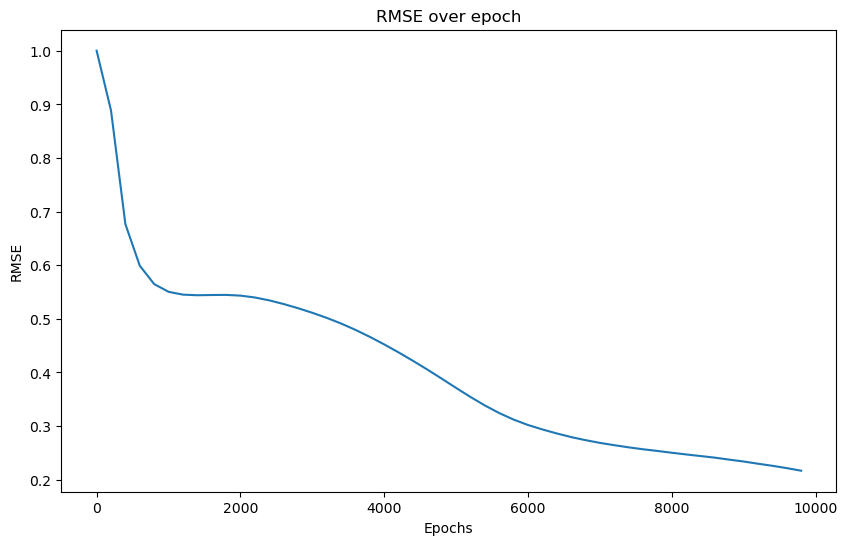

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(x_axis, sum_rmse_te)
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('RMSE over epoch')
plt.show()

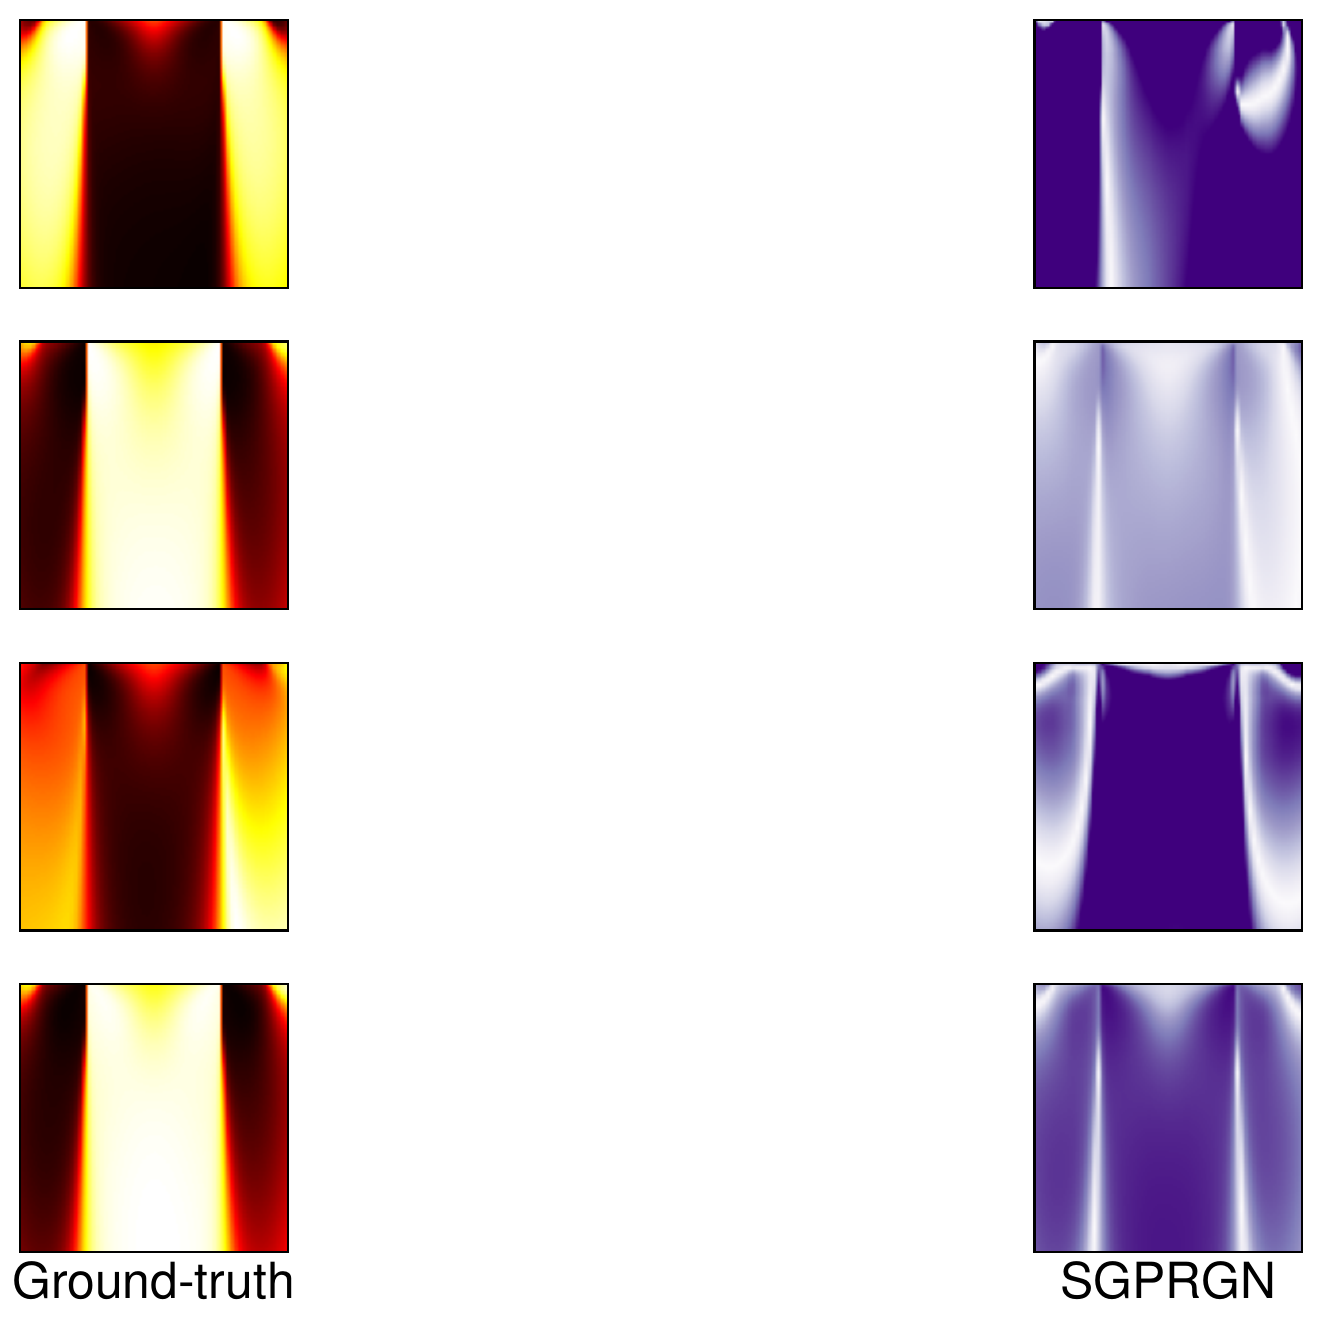

In [1]:
from pdf2image import convert_from_path
from IPython.display import Image, display
pdf_path = "__figs__/errors_Heat_SGPRN.pdf"

# Convert the PDF to images
images = convert_from_path(pdf_path)

images[0].save("__figs__/errors_Heat_SGPRN.png", 'PNG')

display(Image(filename='__figs__/errors_Heat_SGPRN.png'))